### Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

ModuleNotFoundError: No module named 'keras'

In [4]:
df = pd.read_csv("SMSSpamCollection.csv")
df.shape

(5572, 2)

### Data Visualization and Preprocessing

In [5]:
df.head()

,Class,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
#df = df.sample(frac=1, random_state=22).reset_index(drop=True)

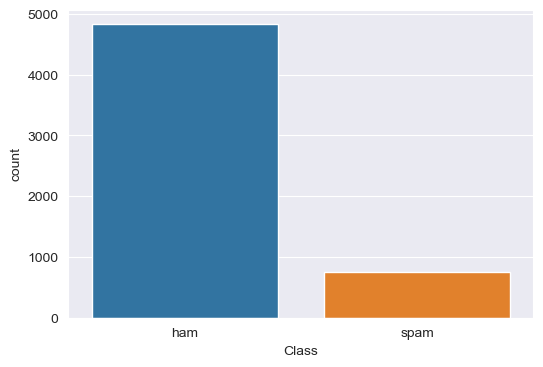

In [7]:
plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(x=df.Class, data=df)
plt.show()

In [8]:
df.isna().sum() # Checking for nan Values

Class    0
sms      0
dtype: int64

In [9]:
df['Class'] = df['Class'].map({'spam':1, 'ham':0})

### Cleaning the corpus

In [10]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [11]:
df['sms_clean'] = df['sms'].apply(clean_text)
df.head()

,Class,sms,sms_clean
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [12]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['sms_clean'] = df['sms_clean'].apply(remove_stopwords)
df.head()

,Class,sms,sms_clean
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts m...
3,0,U dun say so early hor... U c already then say...,dun say early hor already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


In [13]:
df = df.drop('sms', axis=1)
df = df.rename(columns={'sms_clean': 'sms'})
df.head()

,Class,sms
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif oni
2,1,free entry wkly comp win fa cup final tkts m...
3,0,dun say early hor already say
4,0,nah dont think goes usf lives around though


In [14]:
df2 = df.copy()

### WordCloud

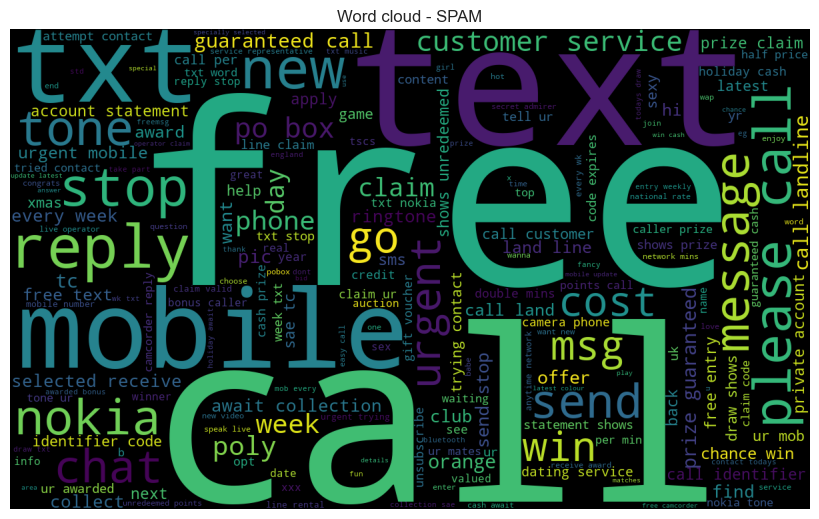

In [15]:
wrds=''
for msg in df[df['Class']==1]['sms']:
    msg=msg.split()
    for words in msg:
        wrds = wrds+words+' '
        
wcloud = WordCloud(width=1200, height=720,random_state=101).generate(wrds)

plt.figure( figsize=(10,5), facecolor='w')
plt.imshow(wcloud)
plt.title('Word cloud - SPAM')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

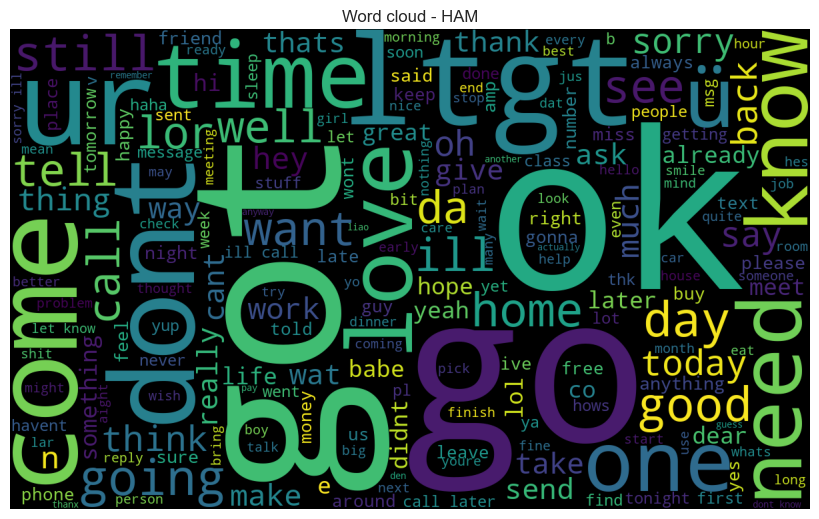

In [16]:
wrds=''
for msg in df[df['Class']==0]['sms']:
    msg=msg.split()
    for words in msg:
        wrds = wrds+words+' '
        
wcloud = WordCloud(width=1200, height=720,random_state=101).generate(wrds)

plt.figure( figsize=(10,5), facecolor='w')
plt.imshow(wcloud)
plt.title('Word cloud - HAM')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Number of words in each text**

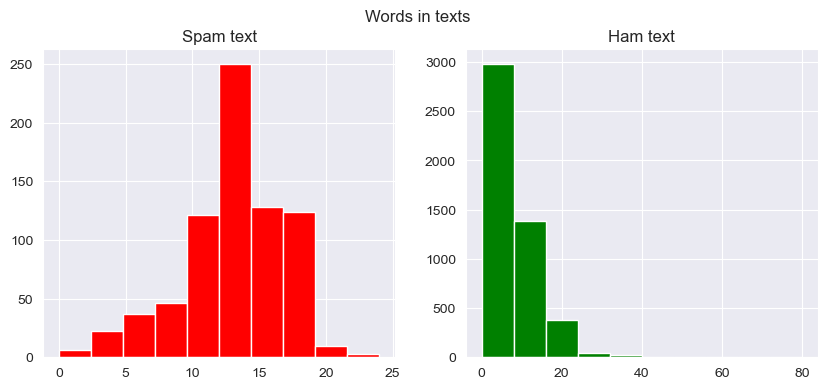

In [66]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10, 4))
text_len=df[df['Class']==1]['sms'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Spam text')
text_len=df[df['Class']==0]['sms'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Ham text')
fig.suptitle('Words in texts')
plt.show()

### Word Frequency

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Unigram Analysis**

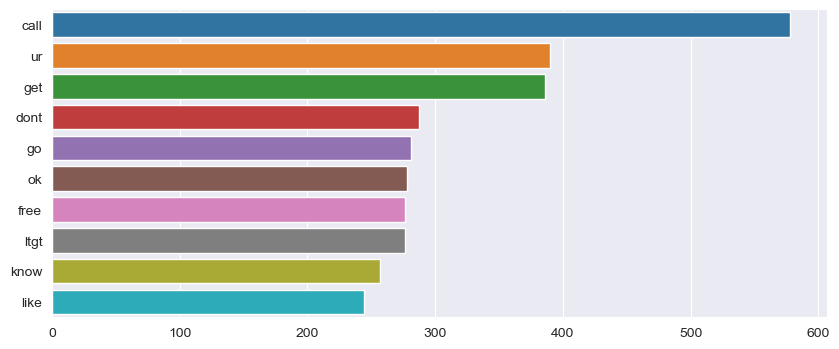

In [68]:
plt.figure(figsize = (10,4))
most_common_uni = get_top_text_ngrams(df.sms,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
plt.show()

**Bigram Analysis**

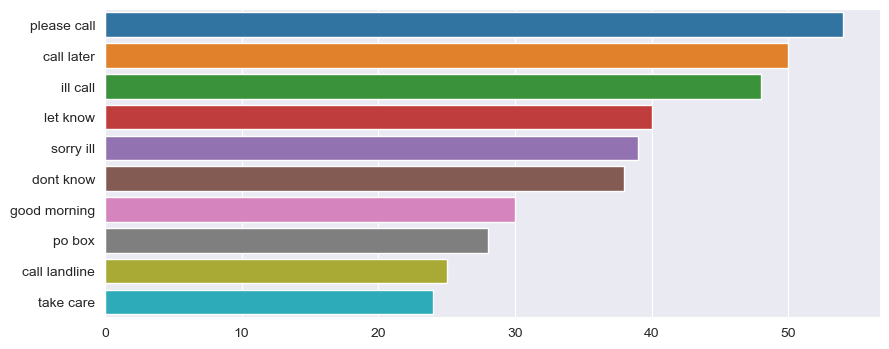

In [69]:
plt.figure(figsize = (10,4))
most_common_bi = get_top_text_ngrams(df.sms,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
plt.show()

**Trigram Analysis**

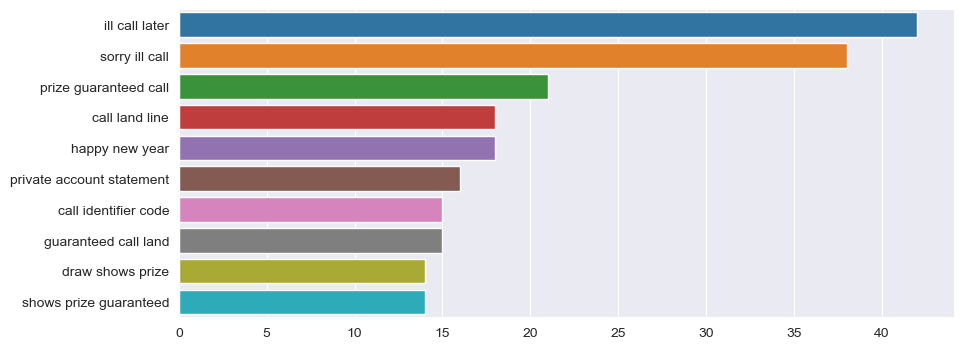

In [70]:
plt.figure(figsize = (10,4))
most_common_tri = get_top_text_ngrams(df.sms,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))
plt.show()

### Stemming

In [71]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [72]:
df = df2.copy()
df['sms_clean'] = df['sms'].apply(stemm_text)
df.head()

,Class,sms,sms_clean
0,0,go jurong point crazy available bugis n great ...,go jurong point crazi avail bugi n great world...
1,0,ok lar joking wif oni,ok lar joke wif oni
2,1,free entry wkly comp win fa cup final tkts m...,free entri wkli comp win fa cup final tkts m...
3,0,dun say early hor already say,dun say earli hor alreadi say
4,0,nah dont think goes usf lives around though,nah dont think goe usf live around though


### Lemmatizer

In [73]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemm_text(text):
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
    return text

In [74]:
df['sms_clean'] = df['sms'].apply(lemm_text)
df.head()

,Class,sms,sms_clean
0,0,go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif oni,ok lar joking wif oni
2,1,free entry wkly comp win fa cup final tkts m...,free entry wkly comp win fa cup final tkts m...
3,0,dun say early hor already say,dun say early hor already say
4,0,nah dont think goes usf lives around though,nah dont think go usf life around though


In [75]:
df = df.drop('sms', axis=1)
df = df.rename(columns={'sms_clean':'sms'})
df2 = df.copy()

### Count Vectorizer

In [76]:
df = df2.copy()

In [77]:
X = df.sms
y = df['Class']

In [78]:
X.shape, y.shape

((5572,), (5572,))

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english')

In [81]:
# vect.get_stop_words()

In [82]:
vect.fit(X_train)

CountVectorizer(stop_words='english')

In [83]:
X_traint = vect.transform(X_train)
X_testt = vect.transform(X_test)

print(X_traint.shape, X_testt.shape)

(3900, 6011) (1672, 6011)


In [84]:
vect.get_feature_names_out()[0:10]

array(['aah', 'aaooooright', 'aathilove', 'aathiwhere', 'abbey',
       'abdomen', 'aberdeen', 'abi', 'ability', 'abiola'], dtype=object)

In [85]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

mnb = MultinomialNB()

mnb.fit(X_traint, y_train)

y_train_pred = mnb.predict(X_traint)
y_train_prob = mnb.predict_proba(X_traint)[:,1]

print('Confusion Matrix: ', '\n', confusion_matrix(y_train, y_train_pred))

print('Accuracy of Train: ',  accuracy_score(y_train, y_train_pred))
print('AUC of Train: ', roc_auc_score(y_train, y_train_prob))

y_test_pred = mnb.predict(X_testt)
y_test_prob = mnb.predict_proba(X_testt)[:,1]

print('\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_test_pred))

print('Accuracy of Test: ',  accuracy_score(y_test, y_test_pred))
print('AUC of Test: ', roc_auc_score(y_test, y_test_prob))

Confusion Matrix:  
 [[3355   28]
 [  23  494]]
Accuracy of Train:  0.9869230769230769
AUC of Train:  0.9939568704828042


Confusion Matrix:  
 [[1427   15]
 [  26  204]]
Accuracy of Test:  0.9754784688995215
AUC of Test:  0.9793252125670868


#### Tf-IDF

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
____

Let's go ahead and see how we can do this in SciKit Learn:

In [86]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(X_traint)
X_traint_tfidf = tfidf_transformer.transform(X_traint).toarray()
X_testt_tfidf = tfidf_transformer.transform(X_testt).toarray()
print(X_traint_tfidf[20])

[0. 0. 0. ... 0. 0. 0.]


In [87]:
print(X_traint_tfidf.shape)
print(type(X_traint_tfidf))

(3900, 6011)
<class 'numpy.ndarray'>


In [88]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

mnb = MultinomialNB()

mnb.fit(X_traint_tfidf, y_train)

y_train_pred = mnb.predict(X_traint_tfidf)
y_train_prob = mnb.predict_proba(X_traint_tfidf)[:,1]

print('Confusion Matrix: ', '\n', confusion_matrix(y_train, y_train_pred))

print('Accuracy of Train: ',  accuracy_score(y_train, y_train_pred))
print('AUC of Train: ', roc_auc_score(y_train, y_train_prob))

y_test_pred = mnb.predict(X_testt_tfidf)
y_test_prob = mnb.predict_proba(X_testt_tfidf)[:,1]

print('\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_test_pred))

print('Accuracy of Test: ',  accuracy_score(y_test, y_test_pred))
print('AUC of Test: ', roc_auc_score(y_test, y_test_prob))

Confusion Matrix:  
 [[3383    0]
 [  93  424]]
Accuracy of Train:  0.9761538461538461
AUC of Train:  0.9930163389481257


Confusion Matrix:  
 [[1442    0]
 [  62  168]]
Accuracy of Test:  0.9629186602870813
AUC of Test:  0.9817282759452453


In [89]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
thresholds[0] = thresholds[0]-1

In [90]:
thresh = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'thresh':thresholds})

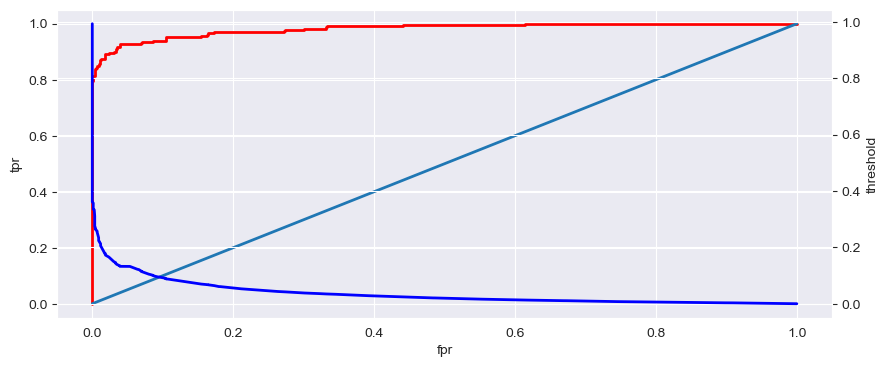

In [91]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(fpr, tpr, lw=2, color='r')
ax.plot(fpr, fpr, lw=2)
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')

ax2 = ax.twinx()
ax2.plot(fpr, thresholds, lw=2, color='b')
ax2.set_ylabel('threshold')
plt.show()

### Word2Vec

In [92]:
df = df2.copy()

In [42]:
from nltk.corpus import stopwords

df['sms'] = df['sms'].str.lower()
stops = set(stopwords.words('english')) 

# tokens of words  
df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row['sms']), axis=1)

#function to remove stop words
def remove_stops(row):
    my_list = row['tokenized_sents']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)
df['clean_sms'] = df.apply(remove_stops, axis=1)
df = df.drop(["sms","tokenized_sents"], axis = 1)

df.head()

,Class,clean_sms,clean_join_sms
0,0,"[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,0,"[ok, lar, joking, wif, oni]",ok lar joking wif oni
2,1,"[free, entry, wkly, comp, win, fa, cup, final,...",free entry wkly comp win fa cup final tkts may...
3,0,"[dun, say, early, hor, already, say]",dun say early hor already say
4,0,"[nah, dont, think, go, usf, life, around, though]",nah dont think go usf life around though


In [45]:
from gensim.models import Word2Vec

In [47]:
EMBEDDING_DIM = 300
w2v_model = Word2Vec(sentences=df['clean_sms'], epochs=10, vector_size=EMBEDDING_DIM, 
                     window=7, min_count=3, sg=1)

In [48]:
len(w2v_model.wv.index_to_key)

1833

In [49]:
w2v_model.wv.most_similar('free', topn=10)

[('colour', 0.9630624651908875),
 ('motorola', 0.961639404296875),
 ('latest', 0.9603519439697266),
 ('update', 0.9602766633033752),
 ('bluetooth', 0.946413516998291),
 ('orange', 0.9460848569869995),
 ('tariff', 0.9435709118843079),
 ('entitled', 0.9427129626274109),
 ('ringtone', 0.940839409828186),
 ('linerental', 0.9399002194404602)]

### Glove

In [50]:
from gensim.models import KeyedVectors

# Load pre-trained GoogleNews word vectors
google_vectors_file = 'E:\Large\glove\GoogleNews-vectors-negative300.bin.gz'
word_vectors = KeyedVectors.load_word2vec_format(google_vectors_file, binary=True)

# Find similar words
similar_words = word_vectors.most_similar('free', topn=10)

# Print similar words and their similarity scores
for word, similarity in similar_words:
    print(word, similarity)

Free 0.6718050241470337
Six_Flags_website_http://www.sixflags.com 0.5262574553489685
FREE 0.5083319544792175
nominal_fee 0.45694470405578613
therapy_systems_NFITS 0.4531921148300171
restricted 0.4485984146595001
complimentary 0.44757080078125
afree 0.44120508432388306
www.dickmorris.com 0.4327717125415802
###-####_artmuseumgr.org 0.4296324551105499


In [51]:
# Install gensim - pip install gensim
word_vectors.most_similar('king')
word_vectors.most_similar(positive=['king','woman'], negative= ['man'])

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674735069275),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.518113374710083),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]